In [36]:
import os
import platform
import cv2 as cv
import json
import numpy as np
import tensorflow as tf
import pandas as pd


from sys import path
path.insert(0, '..')
import model
import config
import utill
import layer

In [6]:
with open('../assets/dataset/gt_train.txt') as file:
  data = json.load(file)

data_training = data[:88000]
data_validation = data [88000:]

print("Data length : {0}".format(len(data)))

Data length : 110000


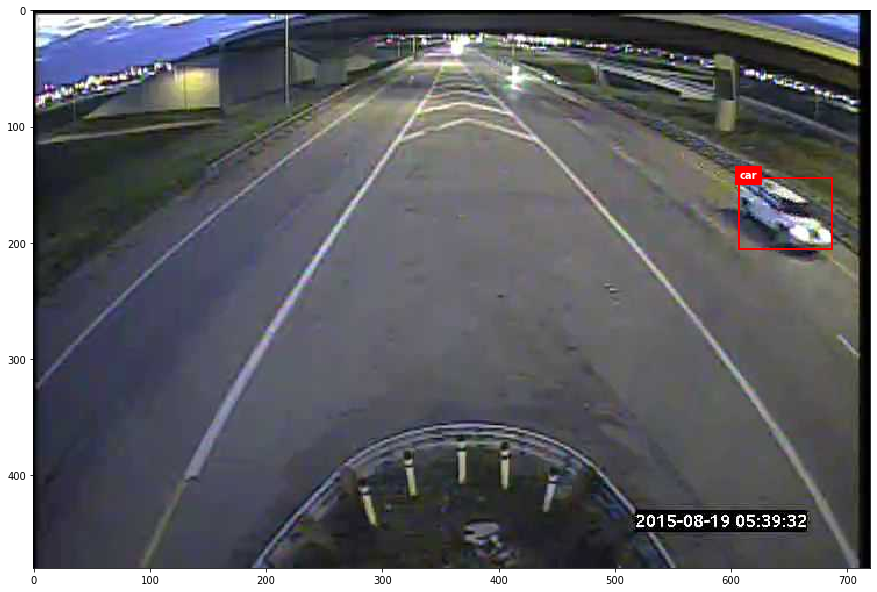

In [28]:
s = 7
img = utill.open_image(os.path.join('../assets/dataset/train',data_validation[s]['filename']), False)
utill.draw_image(img, data_validation[s])

In [8]:
cfg = {
  'image_size' : (416, 416, 3),
  'anchors' : [16, 16, 32, 23, 25, 40, 53, 41, 46, 74, 79, 61, 106, 78, 84, 110, 136, 99, 118, 145, 174, 131, 163, 200, 248, 170, 229, 281, 344, 230],
  'strides' : [8, 16, 32],
  'xyscale': [1.2, 1.1, 1.05],
  'detector_count' : 3,
  'anchor_size_perdetector': 5,

  # Training
  'iou_loss_thresh': 0.5,
  'batch_size': 8,
  'num_gpu': 1,  # 2,

  # Inference
  'max_boxes': 100,
  'iou_threshold': 0.413,
  'score_threshold': 0.55,
}

In [9]:
mdl = model.YoloV4('../assets/class_name.txt', cfg, '../assets/weight.h5')

2022-03-08 15:39:40.517898: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-08 15:39:40.517995: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ozmonday): /proc/driver/nvidia/version does not exist
2022-03-08 15:39:40.518501: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


load from ../assets/weight.h5


2022-03-08 15:39:54.343222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# of bboxes: 2
    x1  y1   x2   y2         class_name     score    w    h
0   27  10  316  118  articulated_truck  0.999259  289  108
1  275  28  351   74                car  0.573100   76   46


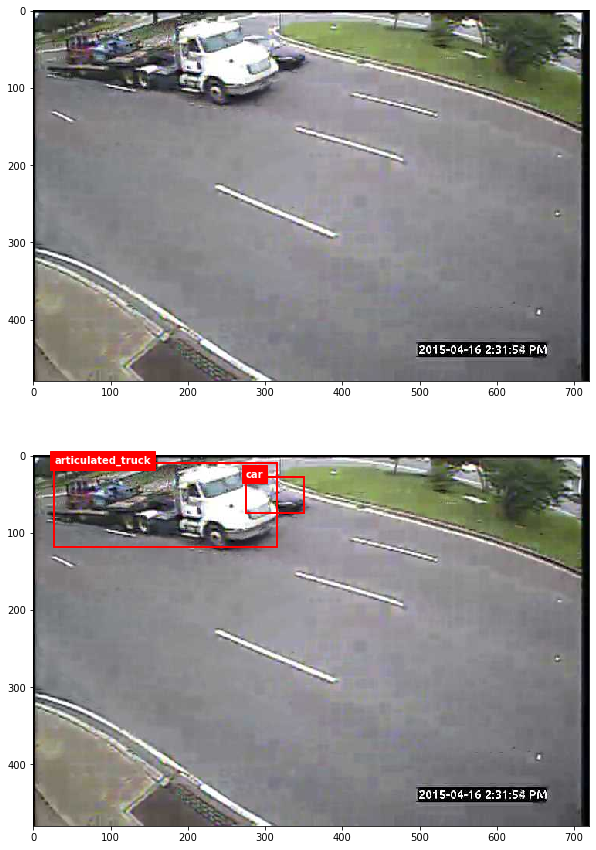

In [10]:
sample_test = os.path.join('../assets/dataset/train', data_validation[12]['filename']) 
mdl.predict(sample_test)

In [33]:
class_name = [line.strip() for line in open('../assets/class_name.txt').readlines()]
print(class_name)

['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']


In [11]:
interpreter = tf.lite.Interpreter(model_path='../assets/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
print(output_details[0]['shape'])
print(output_details[1]['shape'])
print(output_details[2]['shape'])

[ 1 13 13 80]
[ 1 52 52 80]
[ 1 26 26 80]


In [29]:
img_ori = tf.image.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][1]))
img_ori = img_ori / 255
img_exp = np.expand_dims(img_ori, axis=0)

In [39]:
def get_detection_data(model_outputs, img_shape, class_names):
    """
    :param img: target raw image
    :param model_outputs: outputs from inference_model
    :param class_names: list of object class names
    :return:
    """

    num_bboxes = model_outputs[-1][0]
    boxes, scores, classes = [output[0][:num_bboxes] for output in model_outputs[:-1]]
    print(classes)

    h = img_shape[0]
    w = img_shape[1]


    df = pd.DataFrame(boxes, columns=['x1', 'y1', 'x2', 'y2'])
    df[['x1', 'x2']] = (df[['x1', 'x2']] * w).astype('int64')
    df[['y1', 'y2']] = (df[['y1', 'y2']] * h).astype('int64')
    df['class_name'] = np.array(class_names)[int(classes)]
    df['score'] = scores
    df['w'] = df['x2'] - df['x1']
    df['h'] = df['y2'] - df['y1']

    print(f'# of bboxes: {num_bboxes}')
    return df


In [40]:
interpreter.set_tensor(input_details[0]['index'], img_exp)
interpreter.invoke()

anchors = np.array(cfg['anchors']).reshape((3, 5, 2))
large_output = interpreter.get_tensor(output_details[0]['index'])
medium_output = interpreter.get_tensor(output_details[1]['index'])
small_output = interpreter.get_tensor(output_details[2]['index'])
outputs = [small_output, medium_output, large_output]

outputs = layer.yolo_detector(outputs, anchors, len(class_name) , cfg['strides'], cfg['xyscale'])
outputs = utill.nms(outputs, cfg['image_size'], len(class_name), cfg['iou_threshold'], cfg['score_threshold'])
boxes = get_detection_data(outputs, img.shape, class_name)

tf.Tensor([3. 3.], shape=(2,), dtype=float32)


AttributeError: 
        'EagerTensor' object has no attribute 'astype'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

In [12]:
sample = data[:100]
mdl.export_gt(sample, '../assets/dataset/train', '../assets/gt_train')

In [13]:
mdl.export_predict(sample, '../assets/dataset/train',  '../assets/predict')

  0%|          | 0/50 [00:00<?, ?it/s]2022-03-08 15:40:04.354938: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44302336 exceeds 10% of free system memory.
2022-03-08 15:40:04.496080: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44515584 exceeds 10% of free system memory.
2022-03-08 15:40:05.069119: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44302336 exceeds 10% of free system memory.
  2%|▏         | 1/50 [00:05<04:40,  5.73s/it]2022-03-08 15:40:10.163970: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44302336 exceeds 10% of free system memory.
2022-03-08 15:40:10.264514: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44515584 exceeds 10% of free system memory.
100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van'] {'car': 206, 'pickup_truck': 39, 'work_van': 6, 'motorized_vehicle': 21, 'bus': 13, 'bicycle': 2, 'single_unit_truck': 8, 'motorcycle': 1, 'pedestrian': 6, 'articulated_truck': 3, 'non-motorized_vehicle': 1}
fp  2
tp  3
recall  3
prec  3
91.67% = articulated_truck AP 


/home/hadioz/development/python/counting-car/notebook/../model.py:344: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('AP ' + class_name)


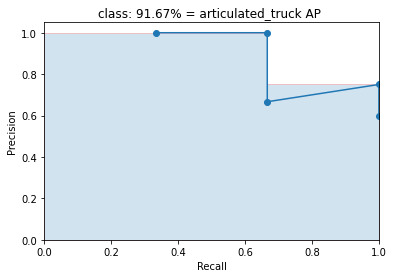

fp  1
tp  2
recall  2
prec  2
83.33% = bicycle AP 


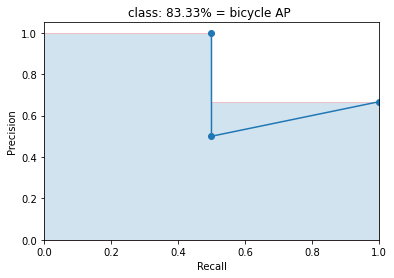

fp  1
tp  11
recall  11
prec  11
84.62% = bus AP 


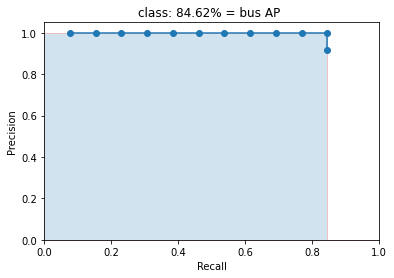

fp  14
tp  192
recall  192
prec  192
92.45% = car AP 


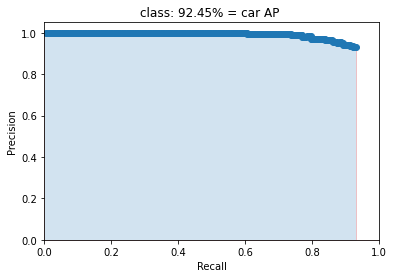

fp  2
tp  1
recall  1
prec  1
50.00% = motorcycle AP 


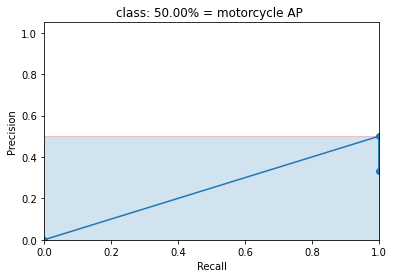

fp  12
tp  8
recall  8
prec  8
21.43% = motorized_vehicle AP 


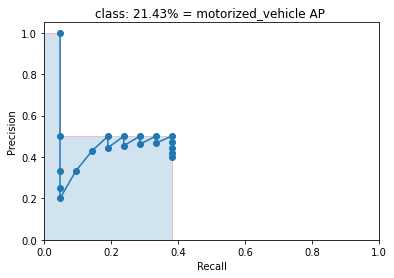

fp  3
tp  0
recall  0
prec  0
0.00% = non-motorized_vehicle AP 


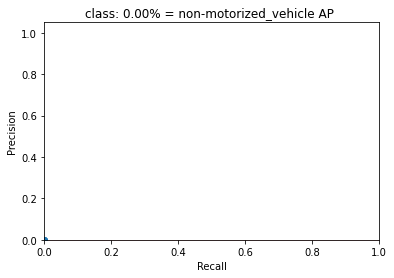

fp  0
tp  5
recall  5
prec  5
83.33% = pedestrian AP 


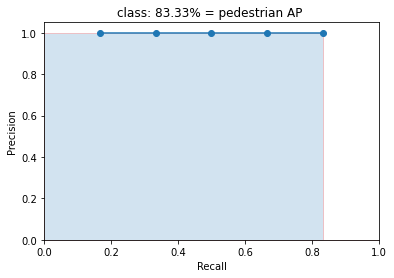

fp  10
tp  36
recall  36
prec  36
90.55% = pickup_truck AP 


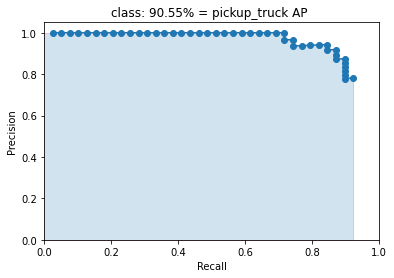

fp  1
tp  6
recall  6
prec  6
75.00% = single_unit_truck AP 


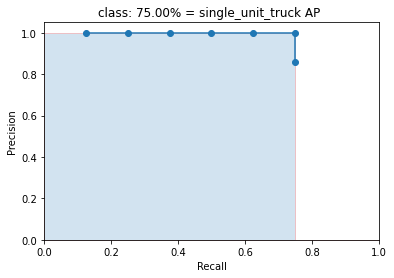

fp  5
tp  5
recall  5
prec  5
69.26% = work_van AP 


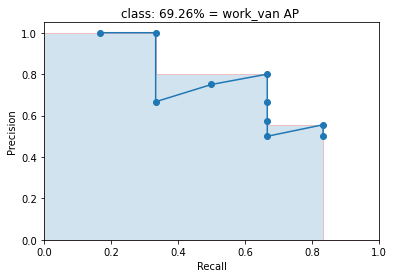

mAP = 67.42%
[('motorcycle', 1), ('non-motorized_vehicle', 1), ('bicycle', 2), ('articulated_truck', 3), ('work_van', 6), ('pedestrian', 6), ('single_unit_truck', 8), ('bus', 13), ('motorized_vehicle', 21), ('pickup_truck', 39), ('car', 206)]


/home/hadioz/development/python/counting-car/notebook/../utill.py:472: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(window_title)


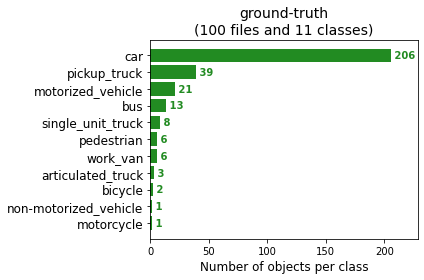

[('bicycle', 3), ('motorcycle', 3), ('non-motorized_vehicle', 3), ('articulated_truck', 5), ('pedestrian', 5), ('single_unit_truck', 7), ('work_van', 10), ('bus', 12), ('motorized_vehicle', 20), ('pickup_truck', 46), ('car', 206)]


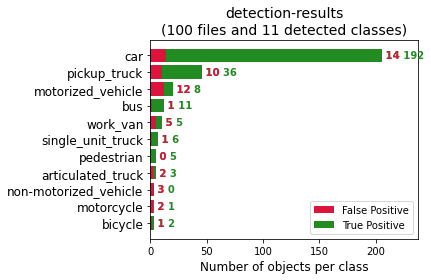

[('non-motorized_vehicle', 0.0), ('motorized_vehicle', 0.21428571428571427), ('motorcycle', 0.5), ('work_van', 0.6925925925925926), ('single_unit_truck', 0.75), ('bicycle', 0.8333333333333333), ('pedestrian', 0.8333333333333334), ('bus', 0.8461538461538461), ('pickup_truck', 0.9055031500683676), ('articulated_truck', 0.9166666666666666), ('car', 0.9244838798087198)]


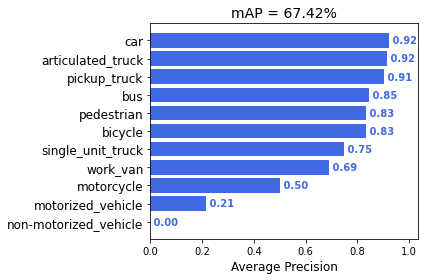

In [13]:
mdl.eval_map( '../assets/gt_train', '../assets/predict', '../assets/test_map/json_tmp', '../assets/test_map')

In [35]:
bicycle = []
for pic in data:
  for obj in pic['objects']:
    if obj['class'] == 'motorcycle':
      bicycle.append(pic)
      break;

In [37]:
with open('../assets/dataset/class/motorcycle.txt', 'w') as file:
    json.dump(bicycle, file)

In [36]:
print(len(bicycle))

1680
